In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import random
from numpy.random import seed
from tensorflow import set_random_seed
import csv
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
seed(10)
set_random_seed(10)

D:\Developer Tools\Anaconda\anaconda_core\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Developer Tools\Anaconda\anaconda_core\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Developer Tools\Anaconda\anaconda_core\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Developer Tools\Anaconda\anaconda_core\lib\site-pack

In [2]:
data = pd.read_csv('rpm.csv')
data.columns = ['rpm', 'throotle']
data.head()

dataset_train = data[0:3000]
dataset_test = data[3000:]

scaler = preprocessing.MinMaxScaler()
data_scaler = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(dataset_train), columns=dataset_train.columns, index=dataset_train.index)
X_train.sample(frac=1)
X_test = pd.DataFrame(scaler.transform(dataset_test),columns=dataset_test.columns,index=dataset_test.index)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2850 samples, validate on 150 samples
Epoch 1/10
2850/2850 [==============================] - 1s 209us/step - loss: 0.0756 - val_loss: 1.6581e-04
Epoch 2/10
2850/2850 [==============================] - 0s 124us/step - loss: 9.0536e-04 - val_loss: 2.4497e-04
Epoch 3/10
2850/2850 [==============================] - 0s 171us/step - loss: 6.2893e-04 - val_loss: 1.9328e-04
Epoch 4/10
2850/2850 [==============================] - 0s 132us/step - loss: 5.1246e-04 - val_loss: 1.4607e-04
Epoch 5/10
2850/2850 [==============================] - 0s 123us/step - loss: 4.2345e-04 - val_loss: 1.6060e-04
Epoch 6/10
2850/2850 [==============================] - 0s 129us/step - loss: 3.5038e-04 - val_loss: 1.4428e-04
Epoch 7/10
2850/2850 [==============================] - 0s 126us/step - loss: 2.9738e-04 - val_loss: 9.6241e-05
Epoch 8/10
2850/2850 [==============================]

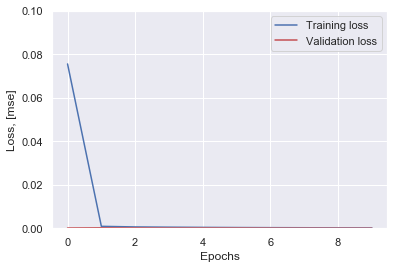

In [3]:

ACTIVATION = 'elu'

model=Sequential()
model.add(Dense(10,activation=ACTIVATION,kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)))

model.add(Dense(2,activation=ACTIVATION,kernel_initializer='glorot_uniform'))
model.add(Dense(10,activation=ACTIVATION,kernel_initializer='glorot_uniform'))
model.add(Dense(X_train.shape[1],kernel_initializer='glorot_uniform'))
model.compile(loss='mse',optimizer='adam')


NUM_EPOCHS=10
BATCH_SIZE=10

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

(0.0, 0.5)

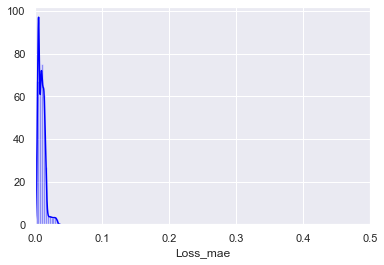

In [4]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index
scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],bins = 10, kde= True,color = 'blue');
plt.xlim([0.0,.5])

In [5]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Error'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Error'] > scored['Threshold']
scored.head()

,Error,Threshold,Anomaly
3000,0.009146,0.3,False
3001,0.009175,0.3,False
3002,0.009234,0.3,False
3003,0.009292,0.3,False
3004,0.009553,0.3,False


In [6]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Error'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Error'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

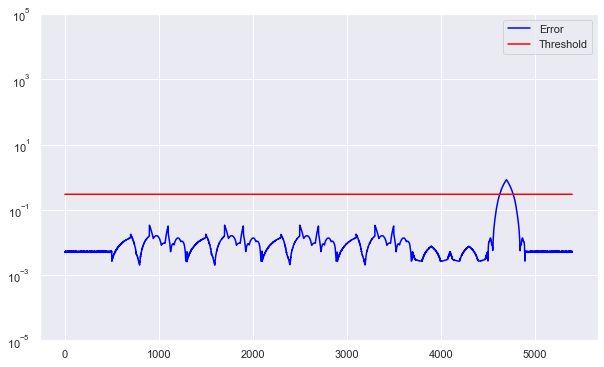

In [7]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-5,1e5], color = ['blue','red'])